In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
f_s = 50
f_e = 500
Voltage = 1.0
Dir_path = str(f_s) + "-" + str(f_e) + "Hz_" + str(Voltage) + "V"
Coeffs = []

with open('Coeff.txt') as file:
  for line in file:
    Coeffs.append(10000/float(line.strip()))
m = np.mean(Coeffs)
Coeffs = Coeffs/m

In [3]:
with open('collected_data_1744163808.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

In [7]:
import numpy as np
from scipy.signal import resample

SAMPLE_RATE = data['sample_rate']
duration = data['duration']
MIN_FREQ = 50
MAX_FREQ = 500

# Load calibration Coeffs
Coeffs = []
with open('Coeff.txt') as file:
    for line in file:
        Coeffs.append(10000 / float(line.strip()))
m = np.mean(Coeffs)
Coeffs = np.array(Coeffs) / m
assert len(Coeffs) == (MAX_FREQ - MIN_FREQ + 1), "Coeff.txt length mismatch"


def map_frequency(value, min_value, max_value, logscale=False):
    if logscale:
        log_min = np.log10(MIN_FREQ)
        log_max = np.log10(MAX_FREQ)
        log_freq = log_min + (log_max - log_min) * ((value - min_value) / (max_value - min_value))
        return 10 ** log_freq
    else:
        return MIN_FREQ + (MAX_FREQ - MIN_FREQ) * ((value - min_value) / (max_value - min_value))


def linterp_index(arr, perc):
    index = perc * (len(arr) - 1)
    lower = int(np.floor(index))
    upper = int(np.ceil(index))
    weight = index - lower
    return arr[lower] * (1 - weight) + arr[upper] * weight


def generate_signal(vib_amp, vib_freq, TOTAL_DURATION_SEC, duration=None, logscale=False):
    if duration is None:
        duration = TOTAL_DURATION_SEC
    elif duration > TOTAL_DURATION_SEC:
        raise ValueError(f"duration must be <= {TOTAL_DURATION_SEC} seconds")

    total_samples = int(TOTAL_DURATION_SEC * SAMPLE_RATE)
    num_output_samples = int(duration * SAMPLE_RATE)
    vib_signal = np.zeros(num_output_samples, dtype=np.float32)

    phase_acc = 0
    for i in range(num_output_samples):
        perc = i / total_samples
        s_freq = linterp_index(vib_freq, perc)
        s_amp = linterp_index(vib_amp, perc)

        current_freq = map_frequency(s_freq, 0, 1, logscale=logscale)
        phase_delta = 2 * np.pi * current_freq / SAMPLE_RATE

        phase_acc += phase_delta
        vib_signal[i] = s_amp * np.sin(phase_acc) * Coeffs[int(current_freq) - MIN_FREQ]

    return vib_signal, duration


def generate_signal_with_thermal(vib_amp, vib_freq, thermal_amp, TOTAL_DURATION_SEC, duration=None, logscale=False, thermal_rate=100):
    vib_signal, actual_duration = generate_signal(vib_amp, vib_freq, TOTAL_DURATION_SEC, duration, logscale)

    # vib_signal의 길이에 맞춰 thermal_amp를 interpolation
    vib_len = len(vib_signal)
    thermal_full = np.interp(
        np.linspace(0, len(thermal_amp) - 1, vib_len),
        np.arange(len(thermal_amp)),
        thermal_amp
    )

    # downsample to thermal_rate (예: 100Hz)
    thermal_downsampled = resample(thermal_full, int(actual_duration * thermal_rate))

    return vib_signal, thermal_downsampled, actual_duration


In [20]:

# vib_signal = data['vib_signal']  # 웹에서 생성된 waveform
vib_amp = data['vib_amp']        # draw canvas의 진폭 (0~1)
vib_freq = data['vib_freq']      # draw canvas의 주파수 (0~1)
thr_amp = data['thr_amp'] # 이미 -6~6으로 정규화된 thermal signal

# vib_signal, thermal_downsampled, actual_duration = generate_signal(vib_amp, vib_freq, duration)

vib_signal, thermal_sampled, actual_duration = generate_signal_with_thermal(vib_amp, vib_freq, thr_amp, 5, duration=duration, logscale=True, thermal_rate=1000)
    

In [21]:
print(SAMPLE_RATE,duration, len(vib_signal),len(thermal_sampled),actual_duration,duration)

10000 4 40000 4000 4 4


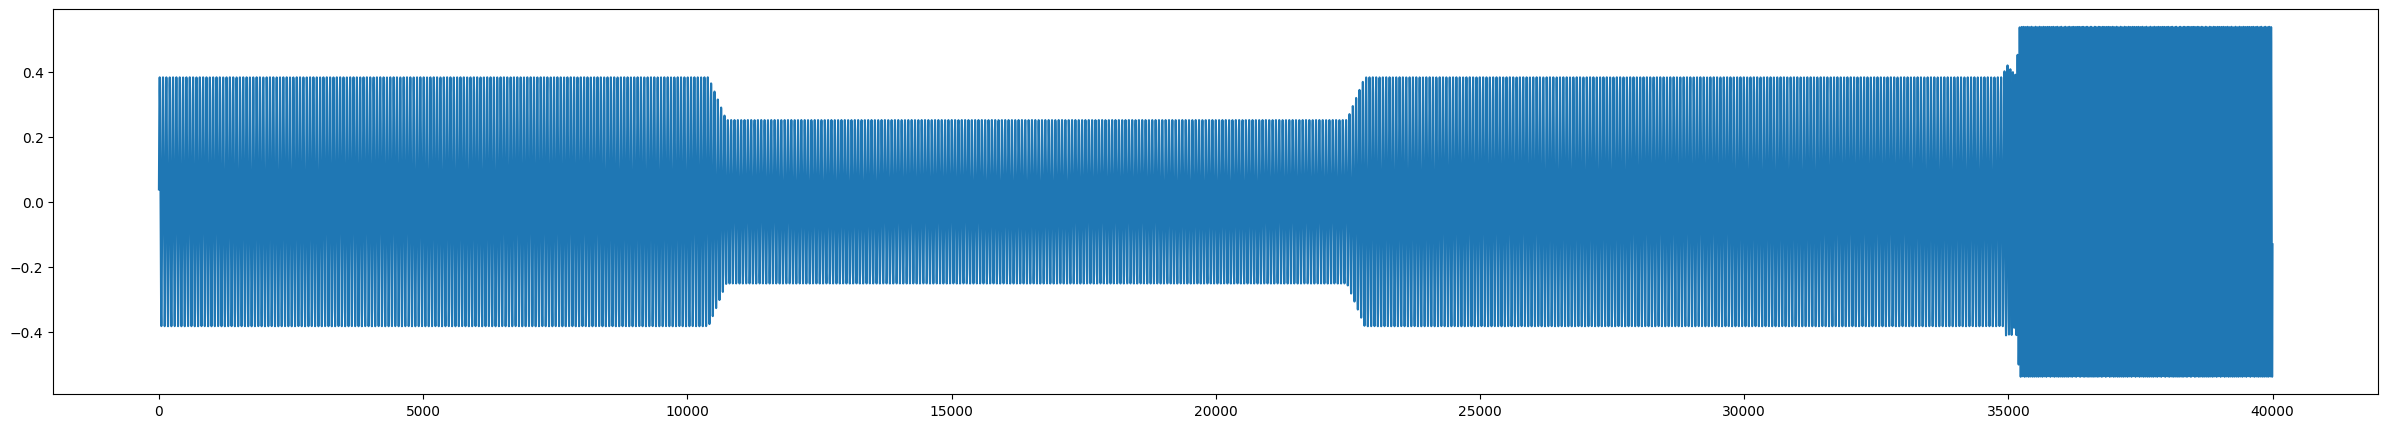

In [22]:
plt.figure(figsize=(30, 5)) 
plt.plot(vib_signal)
plt.show()

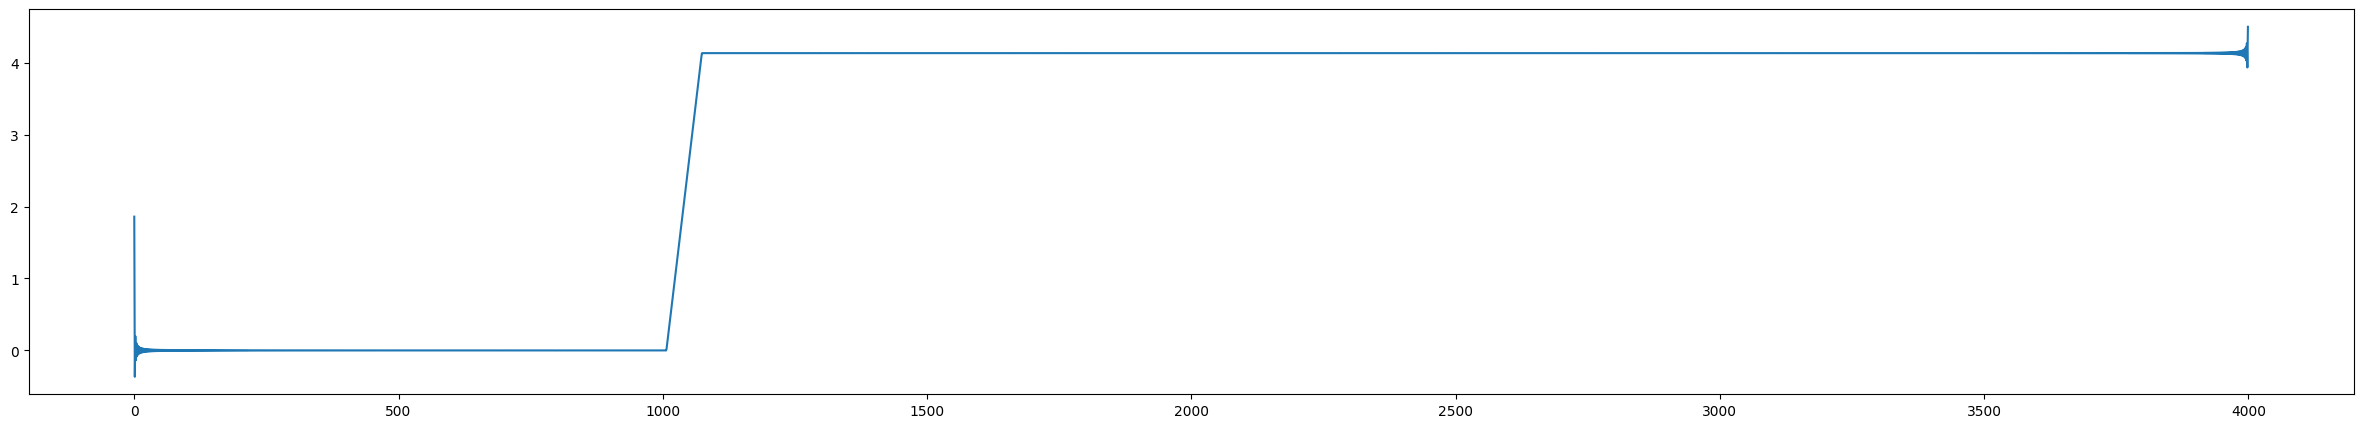

In [23]:
plt.figure(figsize=(30, 5)) 
plt.plot(thermal_sampled)
plt.show()

In [26]:

df = pd.read_csv('arduino_log_1743581095.csv')

df.head()


,Time(ms),Kp,Ki,Kd,CurrentTemp,TargetTemp,PWM,DeltaTemp,Step,BreakTime
0,14933580,128.0,8.0,16.0,25.32,32.5,NAN,0.0,0,0
1,14933593,128.0,8.0,16.0,25.32,32.5,NAN,0.0,0,0
2,14933580,128.0,8.0,16.0,25.32,32.5,NAN,0.0,0,0
3,14933593,128.0,8.0,16.0,25.32,32.5,NAN,0.0,0,0
4,10,128.0,8.0,16.0,25.23,38.5,-255.00,6.0,0,0


In [27]:
print(df.keys())

Index(['Time(ms)', 'Kp', 'Ki', 'Kd', 'CurrentTemp', 'TargetTemp', 'PWM',
       'DeltaTemp', 'Step', 'BreakTime'],
      dtype='object')


In [ ]:
plt.figure(figsize=(30, 5)) 
plt.plot(df['Tar'])
plt.show()

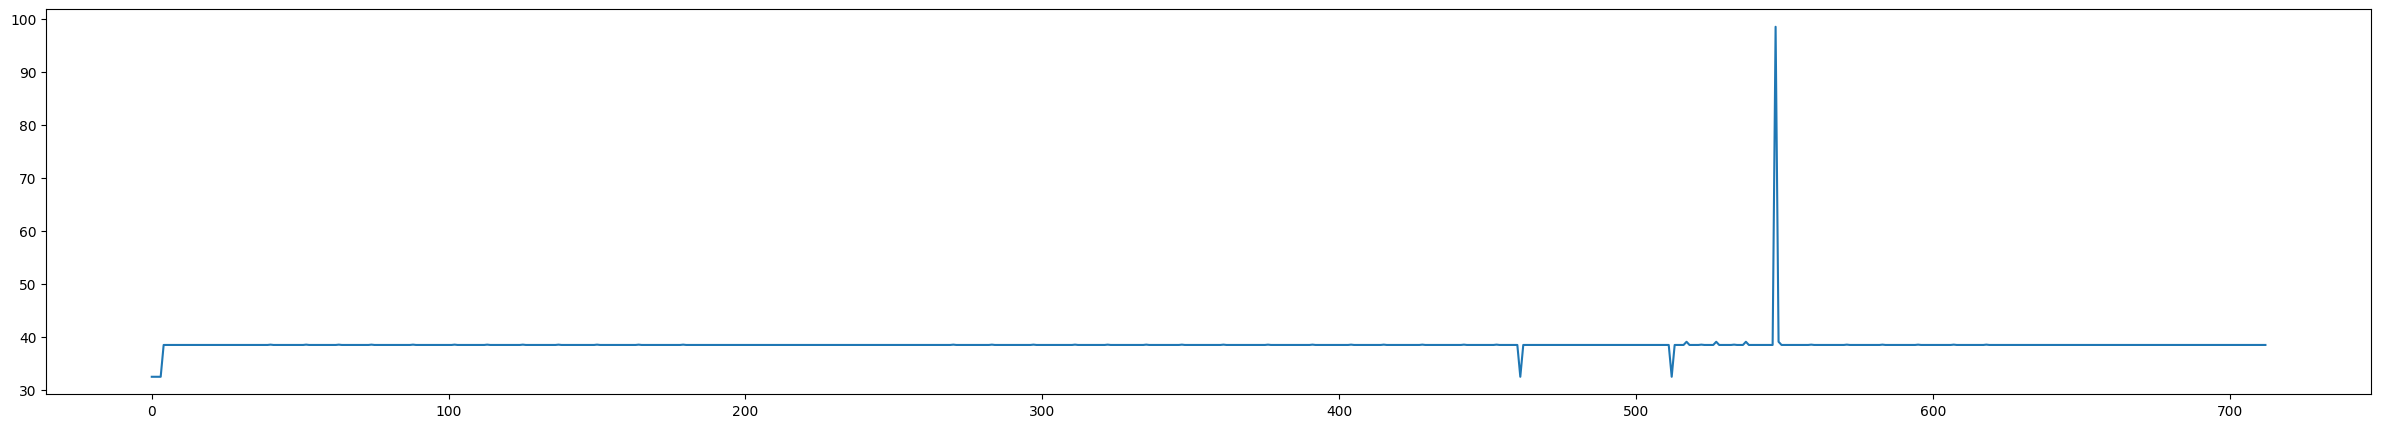

In [28]:
plt.figure(figsize=(30, 5)) 
plt.plot(df['TargetTemp'])
plt.show()



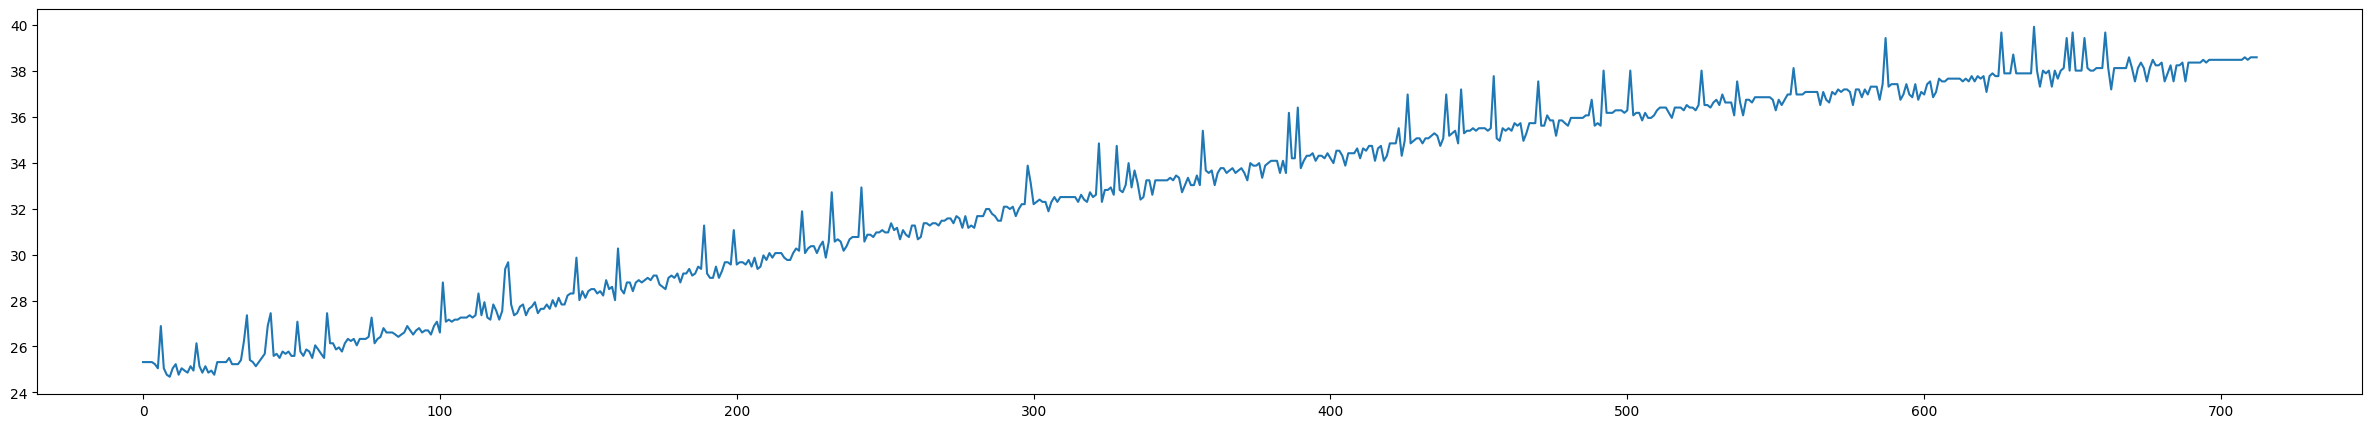

In [29]:
plt.figure(figsize=(30, 5)) 
plt.plot(df['CurrentTemp'])
plt.show()


In [7]:
## DAQ 구동 파트
import nidaqmx

def Init_DAQ():
    ## DAQ Ready
    system = nidaqmx.system.System.local()
    for device in system.devices:
        print(device)
    device = system.devices['Dev1']
    out_chan = device.ao_physical_chans['ao0']
    
    return out_chan.name

def Run_DAQ(out_chan, vib_signal):
    ## DAQ Run
    with nidaqmx.Task() as task:
        task.ao_channels.add_ao_voltage_chan(out_chan)
        task.timing.cfg_samp_clk_timing(SAMPLE_RATE, sample_mode=nidaqmx.constants.AcquisitionType.FINITE, samps_per_chan=SAMPLE_RATE * TOTAL_DURATION_SEC)
        
        task.write(vib_signal, auto_start=True)
        task.wait_until_done()
        task.stop()

In [8]:
out_chan = Init_DAQ()
Run_DAQ(out_chan, vib_signal_result)

Device(name=Dev1)


NameError: name 'vib_signal_result' is not defined

In [9]:
freq = data['vib_freq']
plt.plot(thr_amp)
plt.show()
plt.figure(figsize=(30, 5))  
plt.plot(freq)
plt.figure(figsize=(30, 5))  
plt.plot(Coeffs)
plt.figure(figsize=(30, 5))  
plt.plot(vib_signal_result)
plt.show()

NameError: name 'data' is not defined